In [372]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, true_positive_rate,false_positive_rate

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import numpy as np

In [373]:
#Datei einlesen
df = pd.read_csv("Medicaldataset.csv")
#df = pd.read_csv(r"C:\Users\zahri\anaconda_projects\AsaiProjekt\Asai-Projekt\Medicaldataset.csv")
df = pd.read_csv("/Users/aurelia/Documents/GitHub/Asai-Projekt/Medicaldataset.csv")
#df = pd.read_csv(r"C:\Users\Aurelia\OneDrive\Dokumente\GitHub\Asai-Projekt\Medicaldataset.csv")
df_orginal = df.copy()

In [374]:
#DataFrame-Beispiel Daten
styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.000000,1.800000,0.012000,negative
1,21,1,94,98,46,296.000000,6.750000,1.060000,positive
2,55,1,64,160,77,270.000000,1.990000,0.003000,negative
3,64,1,70,120,55,270.000000,13.870000,0.122000,positive
4,55,1,64,112,65,300.000000,1.080000,0.003000,negative
5,58,0,61,112,58,87.000000,1.830000,0.004000,negative
6,32,0,40,179,68,102.000000,0.710000,0.003000,negative
7,63,1,60,214,82,87.000000,300.000000,2.370000,positive
8,44,0,60,154,81,135.000000,2.350000,0.004000,negative
9,67,1,61,160,95,100.000000,2.840000,0.011000,negative


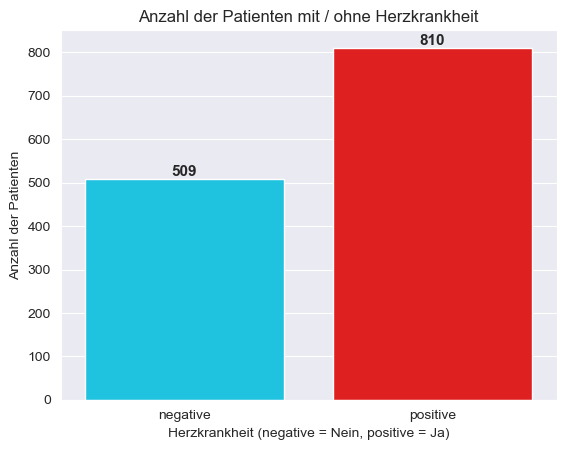

Anzahl der Zeilen (Patienten): 1319
Anzahl der Spalten (Features): 9


In [375]:
#Balkendiagramm Anteil Herzerkrankte

# Balkendiagramm
ax = sns.countplot(x='Result', hue='Result', data=df, palette=['#00d9ff', '#ff0000'], legend=False)

# Achsentitel
plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (negative = Nein, positive = Ja)')
plt.ylabel('Anzahl der Patienten')

# Zahlen über Balken schreiben
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

# Plot anzeigen
plt.show()
print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")

In [376]:
# Daten Vorverarbeitung
# Duplikate checken
# Alle duplizierten Zeilen (inkl. Erstvorkommen)
duplikate_df = df[df.duplicated(keep=False)]

# Anzahl und Prozent Duplikate
anzahl_duplikate = len(duplikate_df)
gesamt = len(df)
prozent_duplikate = (anzahl_duplikate / gesamt) * 100

# Verteilung HeartDisease(Result) in den Duplikaten
verteilung_duplikate = duplikate_df['Result'].value_counts(normalize=True) * 100

# Verteilung HeartDisease(Result) im gesamten DataFrame
verteilung_gesamt = df['Result'].value_counts(normalize=True) * 100

# Ausgabe
print("Gesamtzeilen:", gesamt)
print("Anzahl mehrfach vorkommender Zeilen:", anzahl_duplikate)
print(f"Prozent mehrfach vorkommend: {prozent_duplikate:.2f}%\n")

print("Verteilung von Heartdisease innerhalb der Duplikate:")
if not verteilung_duplikate.empty:
    for wert, proz in verteilung_duplikate.items():
        print(f"  {wert}: {proz:.2f}%")
else:
    print("    - - -")

print("\nGesamtverteilung HeartDisease:")
for wert, proz in verteilung_gesamt.items():
    print(f"  {wert}: {proz:.2f}%")

Gesamtzeilen: 1319
Anzahl mehrfach vorkommender Zeilen: 0
Prozent mehrfach vorkommend: 0.00%

Verteilung von Heartdisease innerhalb der Duplikate:
    - - -

Gesamtverteilung HeartDisease:
  positive: 61.41%
  negative: 38.59%


In [377]:
# Duplikate entfernen
df = df.drop_duplicates()


In [378]:
# Fehlende Werte prüfen
print(df.isnull().sum())

Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64


In [379]:
# Typprüfung
# also ob wirklich die im Datensatz angegebenen Datentypen und Beizeichnungen stimmen
def check_values(df, column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte '{column_type}' nicht im Datensatz gefunden.")
        return

    values = df[column_type].dropna().unique()
    invalid = set(values).difference(set(valid_values))
    if invalid:
        print(f" Ungültige Werte in Spalte '{column_type}': {(invalid)} ")
    else:
        print(f"Alle Werte in Spalte '{column_type}' sind gültig ")


valid_values_dict = {
    "Result": {'negative', 'positive'}
}


def check_if_numeric(df, column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte {column_type}' nicht im Datensatz gefunden.")
        return
    else:
        non_numeric = df[column_type].dropna().apply(lambda x: not isinstance(x, (int, float)))
        if non_numeric.any():
            count_invalid = non_numeric.sum()
            print(f"{count_invalid} nicht numerische Werte in Spalte '{column_type}'")
            print(f"Beispiele: {df[column_type][non_numeric].unique()[:5]}")
        else:
            print(f"Alle Werte in Spalte '{column_type}' sind numerisch.")

numeric_columns = [
    'Age',
    'Gender',
    'Heart rate',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Blood sugar',
    'CK-MB',
    'Troponin',
]
# Anwendung:
for column, valid_set in valid_values_dict.items():
    check_values(df, column, valid_set)

for col in numeric_columns:
    check_if_numeric(df, col, numeric_columns)

Alle Werte in Spalte 'Result' sind gültig 
Alle Werte in Spalte 'Age' sind numerisch.
Alle Werte in Spalte 'Gender' sind numerisch.
Alle Werte in Spalte 'Heart rate' sind numerisch.
Alle Werte in Spalte 'Systolic blood pressure' sind numerisch.
Alle Werte in Spalte 'Diastolic blood pressure' sind numerisch.
Alle Werte in Spalte 'Blood sugar' sind numerisch.
Alle Werte in Spalte 'CK-MB' sind numerisch.
Alle Werte in Spalte 'Troponin' sind numerisch.


In [380]:
# Unrealistische Werte
limits = {
    'Age': (0, 120),
    'Heart rate': (40, 200),
    'Systolic blood pressure': (60, 220),
    'Diastolic blood pressure': (40, 150),
    'Blood sugar': (60, 300),
    'CK-MB': (0, 50),
    'Troponin': (0, 100),
}

print(f"Anzahl an Zeilen (vorher): {len(df)}")


def show_outliers(df, limits_dict):
    for col, (min_val, max_val) in limits_dict.items():
        invalid = df[(df[col] < min_val) | (df[col] > max_val)][col]
        print(f"{col}: {len(invalid)} Werte außerhalb ({min_val}–{max_val})")
        if not invalid.empty:
            print(f"    Beispiele: {invalid.unique()[:5]}")


def remove_outliers(df, limits_dict):
    condition = pd.Series([True] * len(df))
    for col, (min_val, max_val) in limits_dict.items():
        condition &= df[col].between(min_val, max_val)

    return df[condition]


def clip_outliers(df, limits_dict):
    df_clipped = df.copy()
    for col, (min_val, max_val) in limits_dict.items():
        before = df_clipped[col]
        below = before < min_val
        above = before > max_val

        df_clipped[col] = before.clip(lower=min_val, upper=max_val)
    print("\nClipping angewenden:")
    df = df_clipped
    show_outliers(df, limits)
    return df_clipped


show_outliers(df, limits)
clip_outliers(df, limits)
print(f"\nNeue Anzahl an Zeilen (nach Filter): {len(df)}")

Anzahl an Zeilen (vorher): 1319
Age: 0 Werte außerhalb (0–120)
Heart rate: 6 Werte außerhalb (40–200)
    Beispiele: [1111   20   36]
Systolic blood pressure: 4 Werte außerhalb (60–220)
    Beispiele: [ 42 223]
Diastolic blood pressure: 2 Werte außerhalb (40–150)
    Beispiele: [ 38 154]
Blood sugar: 78 Werte außerhalb (60–300)
    Beispiele: [319. 301. 321. 334. 392.]
CK-MB: 86 Werte außerhalb (0–50)
    Beispiele: [300.    94.79  50.46 165.1   96.08]
Troponin: 0 Werte außerhalb (0–100)

Clipping angewenden:
Age: 0 Werte außerhalb (0–120)
Heart rate: 0 Werte außerhalb (40–200)
Systolic blood pressure: 0 Werte außerhalb (60–220)
Diastolic blood pressure: 0 Werte außerhalb (40–150)
Blood sugar: 0 Werte außerhalb (60–300)
CK-MB: 0 Werte außerhalb (0–50)
Troponin: 0 Werte außerhalb (0–100)

Neue Anzahl an Zeilen (nach Filter): 1319


Altersverteilung
count    1319.000000
mean       56.191812
std        13.647315
min        14.000000
25%        47.000000
50%        58.000000
75%        65.000000
max       103.000000
Name: Age, dtype: float64


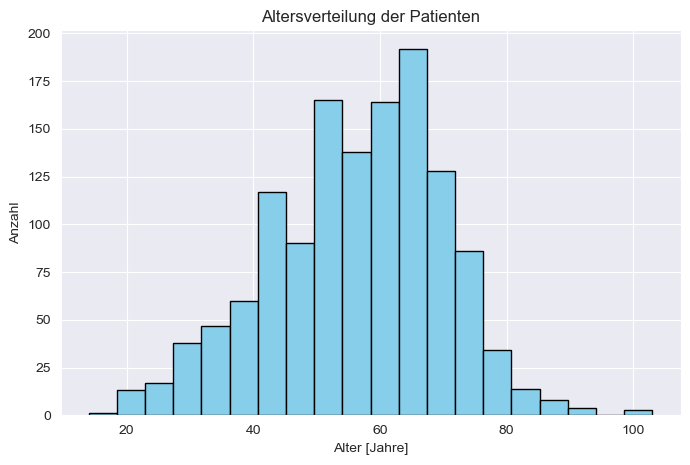

In [381]:
#Bias/Korrelation

print("Altersverteilung")
print(df['Age'].describe())

plt.figure(figsize=(8,5))
plt.hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Altersverteilung der Patienten')
plt.xlabel('Alter [Jahre]')
plt.ylabel('Anzahl')
plt.show()

Geschlechterverteilung 
1=Male, 0=Female
1: 870 Patienten (65.96%)
0: 449 Patienten (34.04%)


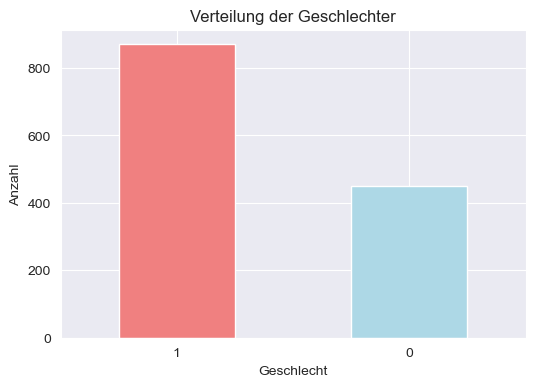

In [382]:
print("Geschlechterverteilung ")
print("1=Male, 0=Female")
gender_counts = df['Gender'].value_counts()
gender_percent = df['Gender'].value_counts(normalize=True) * 100

for sex in gender_counts.index:
    print(f"{sex}: {gender_counts[sex]} Patienten ({gender_percent[sex]:.2f}%)")

plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Verteilung der Geschlechter')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.show()

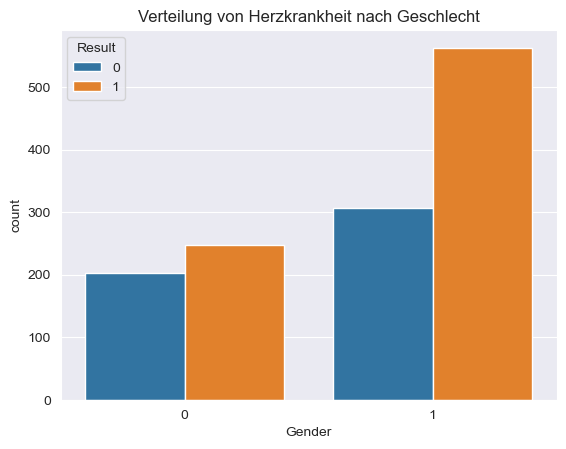

Gender
0    0.550111
1    0.647126
Name: Result, dtype: float64


In [383]:
# Bias: Zielverteilung nach Geschlecht
df['Result'] = df['Result'].map({'positive': 1, 'negative': 0})

sns.countplot(data=df, x='Gender', hue='Result')
plt.title("Verteilung von Herzkrankheit nach Geschlecht")
plt.show()

# Diagnosewahrscheinlichkeit pro Geschlecht
print(df.groupby("Gender")["Result"].mean())

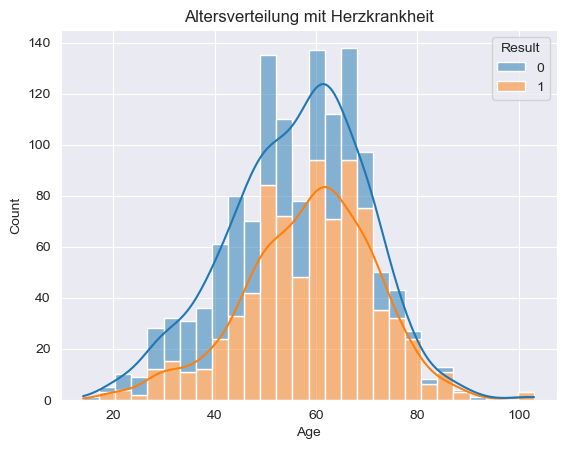

Age_cat
10-20     0.500000
20–30     0.400000
31–40     0.400000
41–50     0.509091
51–60     0.658192
61–120    0.712062
Name: Result, dtype: float64


In [384]:
#Bias: Altersverteilung mit/ohne Herzkrankheit
sns.histplot(data=df, x='Age', hue='Result', kde=True, multiple='stack')
plt.title("Altersverteilung mit Herzkrankheit")
plt.show()

# Altersgruppenbildung für Analyse
df['Age_cat'] = pd.cut(df['Age'], bins=[10, 20, 30, 40, 50, 60, 120],
                        labels=["10-20", "20–30", "31–40", "41–50", "51–60", "61–120"])
print(df.groupby("Age_cat", observed=True)["Result"].mean())

In [385]:
#Random Forest test?


In [386]:
# Feature Engineering

#Heartrate
def heartrate_age_category(row):
    heartrate = row['Heart rate']
    age = row['Age']
    expected_heartrate = 220 - age

    if heartrate < 0.7 * expected_heartrate:
        return 1
    elif 0.7 * expected_heartrate <= heartrate <= expected_heartrate:
        return 2
    elif expected_heartrate < heartrate <= 1.1 * expected_heartrate:
        return 3
    else:
        return 4

df['Heart rate'] = df.apply(heartrate_age_category, axis=1)

# Systolic blood pressure
def systolicBP_categorization(bp):
    if bp < 120:
        return 100
    elif 120<= bp <= 129:
        return 125
    elif 130<= bp <= 139:
        return 135
    elif 140<= bp <= 179:
        return 160
    else: return 190

df['Systolic blood pressure'] = df['Systolic blood pressure'].apply(systolicBP_categorization)

# Diastolic blood pressure
def diastolicBP_categorization(bp):
    if bp < 80:
        return 50
    elif bp < 90:
        return 85
    elif bp < 120:
        return 110
    else: return 140

df['Diastolic blood pressure'] = df['Diastolic blood pressure'].apply(diastolicBP_categorization)

# Blood Sugar
def blood_sugar_category(sugar):
    if sugar < 60:
        return 30
    elif sugar < 90:
        return 80
    elif sugar < 120:
        return 100
    elif sugar < 180:
        return 150
    else: return 200
df['Blood sugar'] = df['Blood sugar'].apply(blood_sugar_category)

# CK-MB
def ckMb_category(ckMb):
    if ckMb < 5:
        return 2.5
    elif ckMb < 25:
        return 15
    else: return 50
df['CK-MB'] = df['CK-MB'].apply(ckMb_category)

# Troponin
def troponin_gender_category(row):
    troponin = row['Troponin']
    gender = row['Gender']
    if gender == 1:  # männlich
        return 0 if troponin <= 0.034 else 1
    else:            # weiblich
        return 0 if troponin <= 0.016 else 1

df['Troponin'] = df.apply(troponin_gender_category, axis=1)

# Age category
def age_category(age_group):
    if age_group == '10–20':
        return 16
    elif age_group == '20-30':
        return 25
    elif age_group == '31–40':
        return 36
    elif age_group == '41–50':
        return 46
    elif age_group == '51–60':
        return 56
    elif age_group == '61–120':
        return 90
    else:
        return 0

df['Age_cat'] = df['Age_cat'].apply(age_category)


styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result,Age_cat
0,64,1,1,160,85,150,2.500000,0,0,90
1,21,1,1,100,50,200,15.000000,1,1,0
2,55,1,1,160,50,200,2.500000,0,0,56
3,64,1,1,125,50,200,15.000000,1,1,90
4,55,1,1,100,50,200,2.500000,0,0,56
5,58,0,1,100,50,80,2.500000,0,0,56
6,32,0,1,160,50,100,2.500000,0,0,36
7,63,1,1,190,85,80,50.000000,1,1,90
8,44,0,1,160,85,150,2.500000,0,0,46
9,67,1,1,160,110,100,2.500000,0,0,90


In [387]:
scaler = MinMaxScaler()
scale_cols = ["Heart rate", "Systolic blood pressure", "Diastolic blood pressure", "Blood sugar", "CK-MB", "Troponin", "Age_cat"]
df[scale_cols] = scaler.fit_transform(df[scale_cols])

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result,Age_cat
0,64,1,0.000000,0.666667,0.388889,0.705882,0.000000,0.000000,0,1.000000
1,21,1,0.000000,0.000000,0.000000,1.000000,0.263158,1.000000,1,0.000000
2,55,1,0.000000,0.666667,0.000000,1.000000,0.000000,0.000000,0,0.622222
3,64,1,0.000000,0.277778,0.000000,1.000000,0.263158,1.000000,1,1.000000
4,55,1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0,0.622222
5,58,0,0.000000,0.000000,0.000000,0.294118,0.000000,0.000000,0,0.622222
6,32,0,0.000000,0.666667,0.000000,0.411765,0.000000,0.000000,0,0.400000
7,63,1,0.000000,1.000000,0.388889,0.294118,1.000000,1.000000,1,1.000000
8,44,0,0.000000,0.666667,0.388889,0.705882,0.000000,0.000000,0,0.511111
9,67,1,0.000000,0.666667,0.666667,0.411765,0.000000,0.000000,0,1.000000


In [388]:
# Train Test Split für RF, LR, Stacking

# 1. Daten vorbereiten: Heartdisease spalte und alte age Spalte entfernen
X = df.drop(columns=['Result', 'Age'])
y = df['Result']

# 2. Trainings-/Testdaten Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.8928


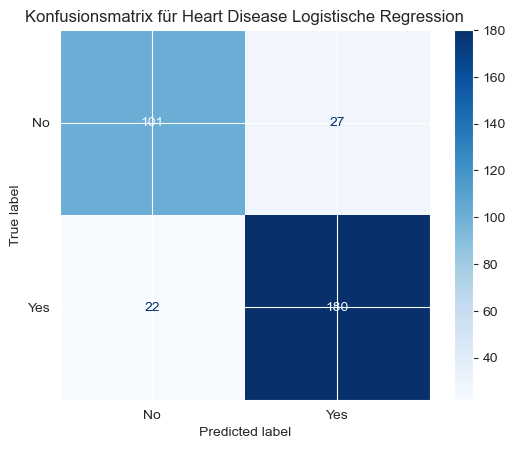

Genauigkeit: 0.8515151515151516

Fairness-Analyse nach 'Gender':
        accuracy  precision    recall  f1_score  selection_rate
Gender                                                         
0       0.953704   0.968254  0.953125  0.960630        0.583333
1       0.801802   0.826389  0.862319  0.843972        0.648649
Demographic Parity Difference: 0.065


In [389]:
#Random Forest mit Gridsearch


# 3. Parametergrid für rf
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 4. Random Forest mit GridSearchCV
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

# 5. Beste Parameter und beste Score ausgeben
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")
# 6. Modell evaluieren
best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

#7. Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#8. Fairness-Analyse nach Geschlecht
# Sensitives Merkmal extrahieren (Gender)
sensitive_feature = df.loc[X_test.index, "Gender"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Gender':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

Bester CV-Score (grid_search.best_score_): 0.8979


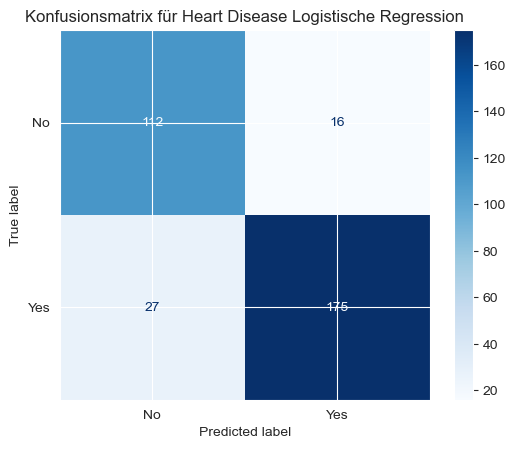

Genauigkeit: 0.8696969696969697

Fairness-Analyse nach 'Gender':
        accuracy  precision    recall  f1_score  selection_rate
Gender                                                         
0       0.953704   0.968254  0.953125  0.960630        0.583333
1       0.828829   0.890625  0.826087  0.857143        0.576577
Demographic Parity Difference: 0.007


In [390]:
#Random Forest mit Gridsearch und balanced


# 3. Parametergrid für rf
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 4. Random Forest mit GridSearchCV
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

# 5. Beste Parameter und beste Score ausgeben
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")
# 6. Modell evaluieren
best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

#7. Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#8. Fairness-Analyse nach Geschlecht
# Sensitives Merkmal extrahieren (Gender)
sensitive_feature = df.loc[X_test.index, "Gender"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Gender':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


In [391]:
# Frauenanteil oversampeln

# 3. Oversampling von Frauen im Trainingsteil
train_df = X_train.copy()
train_df["Result"] = y_train

# Get Frauen (Sex == 0) und Männer
women = train_df[train_df["Gender"] == 0]
men = train_df[train_df["Gender"] == 1]

# Frauen duplizieren, bis gleiche Anzahl wie Männer
women_oversampled = women.sample(n=len(men), replace=True, random_state=42)

# Kombinieren
train_balanced = pd.concat([men, women_oversampled])
X_train_balanced = train_balanced.drop(columns="Result")
y_train_balanced = train_balanced["Result"]

Neue Verteilung im Training:
Gender
1    648
0    648
Name: count, dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.9152


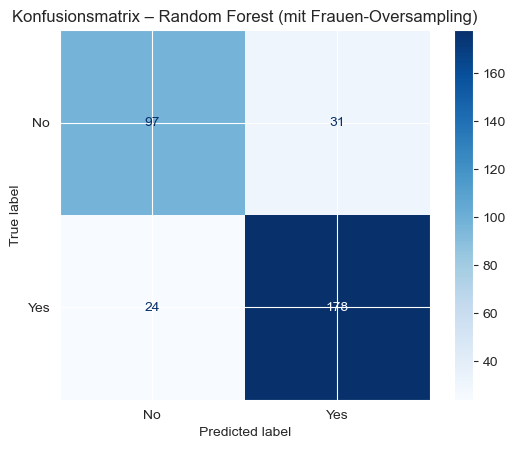

Genauigkeit: 0.8333333333333334

Fairness-Analyse nach 'Sex':
        accuracy  precision    recall  f1_score  selection_rate
Gender                                                         
0       0.935185   0.952381  0.937500  0.944882        0.583333
1       0.783784   0.808219  0.855072  0.830986        0.657658
Demographic Parity Difference: 0.074


In [392]:
#Random Forest MIT Oversamling der Frauen

print(f"Neue Verteilung im Training:\n{X_train_balanced['Gender'].value_counts()}")

# 4. Parametergrid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 5. GridSearchCV
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_balanced, y_train_balanced)

# 6. Bestes Modell
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

# 7. Vorhersage & Evaluation
y_pred_rand = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix – Random Forest (mit Frauen-Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

# 8. Fairness-Analyse
sensitive_feature = df.loc[X_test.index, "Gender"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Gender':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Neue Verteilung im Training:
Gender
1    648
0    648
Name: count, dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.9144


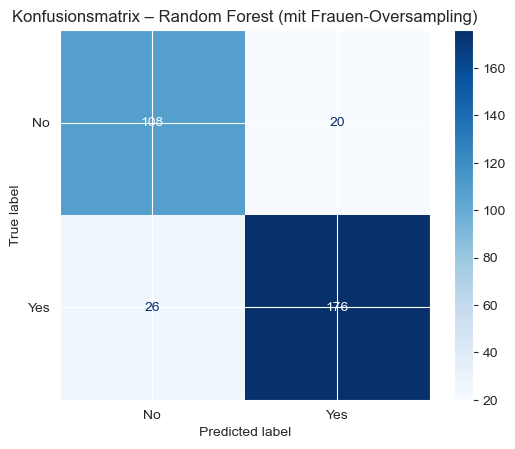

Genauigkeit: 0.8606060606060606

 Predictive Parity (Female): 0.952
 Predictive Parity (Male):   0.872
 Predictive Parity Difference: 0.080

Fairness-Analyse nach 'Sex':
        accuracy  precision   recall  f1_score  selection_rate  \
Gender                                                           
0       0.935185   0.952381  0.93750  0.944882        0.583333   
1       0.824324   0.872180  0.84058  0.856089        0.599099   

        false_positive_rate  true_positive_rate  
Gender                                           
0                  0.068182             0.93750  
1                  0.202381             0.84058  
Demographic Parity Difference: 0.016


In [393]:
#Random Forest MIT Oversamling der Frauen + balanced

print(f"Neue Verteilung im Training:\n{X_train_balanced['Gender'].value_counts()}")

# 4. Parametergrid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 5. GridSearchCV
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_balanced, y_train_balanced)
best_forest_model = grid_search.best_estimator_

# 6. Bestes Modell
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

# 7. Vorhersage & Evaluation
y_pred_rand = best_forest_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix – Random Forest (mit Frauen-Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#Konfusionsmatrix nach mann und frau
# True-Labels und Vorhersagen für jede Gruppe extrahieren
y_true_female = y_test[sensitive_feature == 0]
y_pred_female = y_pred_rand[sensitive_feature == 0]

y_true_male = y_test[sensitive_feature == 1]
y_pred_male = y_pred_rand[sensitive_feature == 1]

# Precision (predictive parity) für beide Gruppen
precision_female = precision_score(y_true_female, y_pred_female)
precision_male = precision_score(y_true_male, y_pred_male)

# Predictive Parity Difference berechnen
pp_diff = abs(precision_female - precision_male)

print(f"\n Predictive Parity (Female): {precision_female:.3f}")
print(f" Predictive Parity (Male):   {precision_male:.3f}")
print(f" Predictive Parity Difference: {pp_diff:.3f}")

# 8. Fairness-Analyse
sensitive_feature = df.loc[X_test.index, "Gender"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Gender':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

Troponin: 0.2388 ± 0.0205
CK-MB: 0.1570 ± 0.0143
Gender: 0.0055 ± 0.0048
Heart rate: 0.0039 ± 0.0014
Age_cat: -0.0027 ± 0.0057
Systolic blood pressure: -0.0030 ± 0.0073
Diastolic blood pressure: -0.0048 ± 0.0053
Blood sugar: -0.0052 ± 0.0081


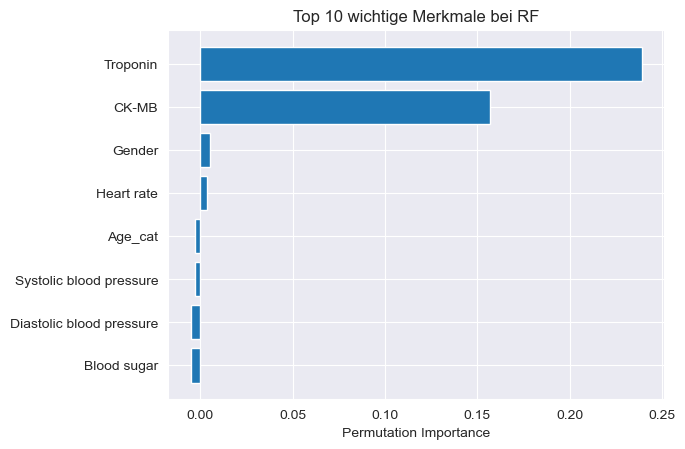

In [394]:
#Top 10 Wichtigste Merkmale bei RF
from sklearn.inspection import permutation_importance

result = permutation_importance(best_forest_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# Plot
import matplotlib.pyplot as plt

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei RF")
plt.show()

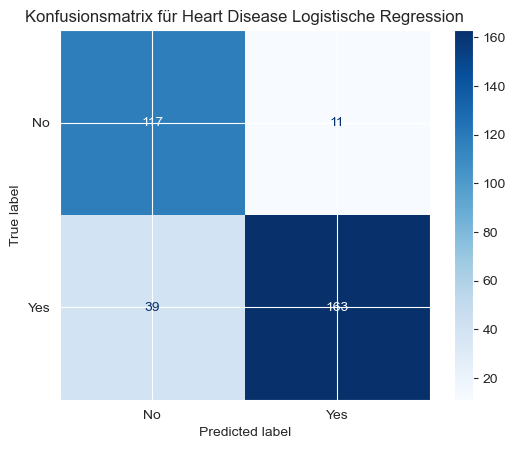

Genauigkeit: 0.8484848484848485
Fairness-Analyse nach 'Gender':
        accuracy  precision    recall  f1_score  selection_rate
Gender                                                         
0       0.898148   1.000000  0.828125  0.905983        0.490741
1       0.824324   0.909091  0.797101  0.849421        0.545045
Demographic Parity Difference: 0.054


In [395]:
#logisticRegeression balanced

modelLogistic = LogisticRegression(max_iter=1000, class_weight='balanced')
modelLogistic.fit(X_train, y_train)

y_pred = modelLogistic.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Genauigkeit:", accuracy)

#Fariness:

# Sensitives Merkmal extrahieren (Gender)
sensitive_feature = df.loc[X_test.index, "Gender"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)

print("Fairness-Analyse nach 'Gender':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


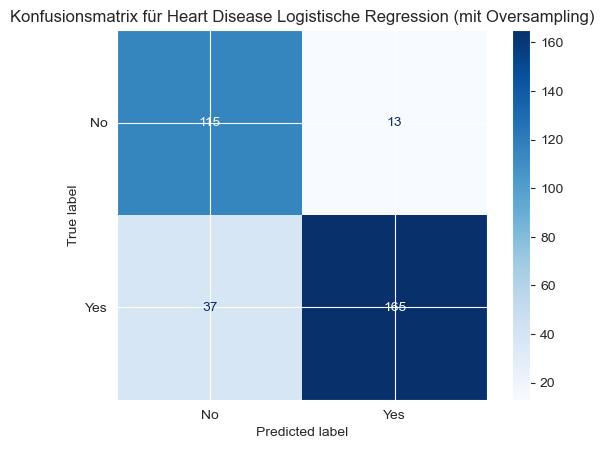

Genauigkeit: 0.8484848484848485

Fairness-Analyse nach 'Sex':
        accuracy  precision    recall  f1_score  selection_rate
Gender                                                         
0       0.888889   0.964286  0.843750  0.900000        0.518519
1       0.828829   0.909836  0.804348  0.853846        0.549550
Demographic Parity Difference: 0.031


In [396]:
#lr mit oversampling der Frauen +balanded

# 4. Modell trainieren
best_lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
best_lr_model.fit(X_train_balanced, y_train_balanced)

# 5. Vorhersage und Evaluation
y_pred_log = best_lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression (mit Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_log)
print("Genauigkeit:", accuracy)

#Fairness
# Sensitives Merkmal extrahieren (Gender)
sensitive_feature = df.loc[X_test.index, "Gender"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_log, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_log, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Troponin: 0.2552 ± 0.0209
CK-MB: 0.1382 ± 0.0183
Diastolic blood pressure: 0.0000 ± 0.0014
Heart rate: 0.0000 ± 0.0000
Systolic blood pressure: -0.0027 ± 0.0044
Gender: -0.0030 ± 0.0078
Blood sugar: -0.0033 ± 0.0050
Age_cat: -0.0052 ± 0.0072


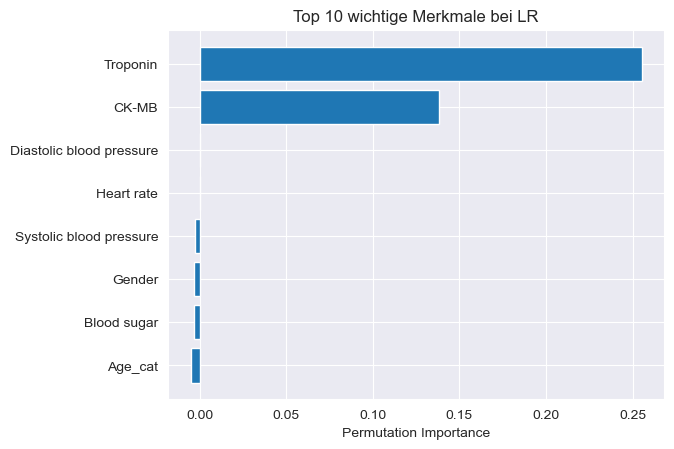

In [397]:
#Top 10 wichtigste Merkmale bei LR
result = permutation_importance(best_lr_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei LR")
plt.show()

🔍 Genauigkeit des Stacking-Modells: 0.8424242424242424


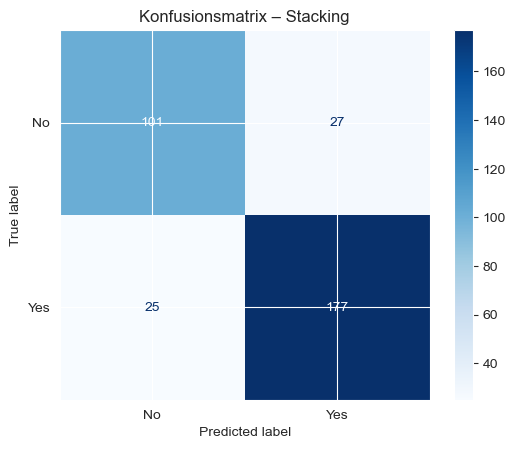


📋 Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       128
           1       0.87      0.88      0.87       202

    accuracy                           0.84       330
   macro avg       0.83      0.83      0.83       330
weighted avg       0.84      0.84      0.84       330



In [398]:
# Stacking mit xgboost, lr, rf

# 3 base model: best_forest_model und best_lr_model

xgb_model = XGBClassifier(
    eval_metric='logloss',  # wichtig für Klassifikation
    random_state=42
)
# 4. Meta-Modell
meta_model = LogisticRegression(max_iter=1000)

# 5. StackingClassifier
stack_model = StackingClassifier(
    estimators=[
        ('rf', best_forest_model),
        ('xgb', xgb_model),
        ('lr', best_lr_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# 6. Training
stack_model.fit(X_train, y_train)

# 7. Vorhersage
y_pred_stack = stack_model.predict(X_test)

# 8. Auswertung
accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit des Stacking-Modells:", accuracy)

cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")
plt.title("Konfusionsmatrix – Stacking")
plt.show()

print("\n Klassifikationsbericht:")
print(classification_report(y_test, y_pred_stack))


/opt/anaconda3/envs/Asai-Projekt/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:43:14] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[20:43:15] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[20:43:15] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[20:43:15] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[20:43:15] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abw

Genauigkeit (Stacking): 0.8424242424242424
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       128
           1       0.87      0.88      0.87       202

    accuracy                           0.84       330
   macro avg       0.83      0.83      0.83       330
weighted avg       0.84      0.84      0.84       330



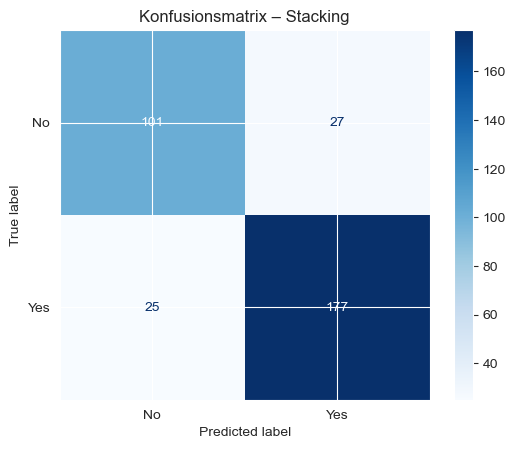


Fairness-Analyse (Stacking):
        accuracy  precision    recall  f1_score  selection_rate
Gender                                                         
0       0.953704   0.968254  0.953125  0.960630        0.583333
1       0.788288   0.822695  0.840580  0.831541        0.635135
Demographic Parity Difference (Stacking): 0.052


In [403]:
best_rf_params = grid_search.best_params_

# Base models mit besten Werten
rf_model = RandomForestClassifier(**best_rf_params, class_weight='balanced', random_state=42)
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Meta model
meta_model = LogisticRegression(max_iter=1000, random_state=42)

stack_model = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('xgb', xgb_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack_model.fit(X_train_balanced, y_train_balanced)

y_pred_stack = stack_model.predict(X_test)

print("Genauigkeit (Stacking):", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")
plt.title("Konfusionsmatrix – Stacking")
plt.show()

sensitive_feature = df.loc[X_test.index, "Gender"]

frame_stack = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)
print("\nFairness-Analyse (Stacking):")
print(frame_stack.by_group)

dp_diff_stack = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference (Stacking): {dp_diff_stack:.3f}")

Genauigkeit (Stacking): 0.8484848484848485
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       128
           1       0.86      0.90      0.88       202

    accuracy                           0.85       330
   macro avg       0.84      0.83      0.84       330
weighted avg       0.85      0.85      0.85       330



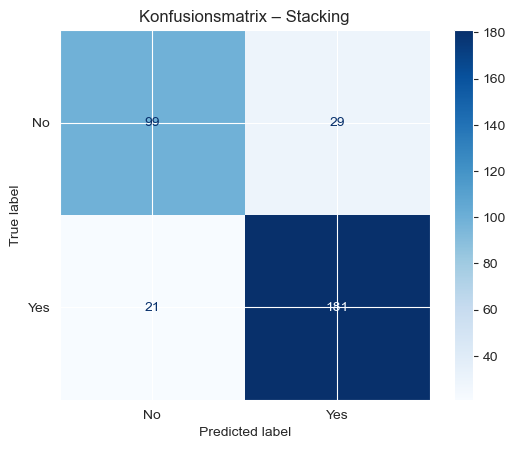


Fairness-Analyse (Stacking):
        accuracy  precision    recall  f1_score  selection_rate
Gender                                                         
0       0.944444   0.953125  0.953125  0.953125        0.592593
1       0.801802   0.821918  0.869565  0.845070        0.657658
Demographic Parity Difference (Stacking): 0.065


In [402]:
# 1. Base-Modelle auf X_train_balanced trainieren
rf_model.fit(X_train_balanced, y_train_balanced)
lr_model.fit(X_train_balanced, y_train_balanced)

# 2. Predictions der Base-Modelle auf dem Trainingsset
rf_preds = rf_model.predict_proba(X_train_balanced)[:, 1]
lr_preds = lr_model.predict_proba(X_train_balanced)[:, 1]

# 3. Stack als neues Feature-Set
X_meta = np.column_stack((rf_preds, lr_preds))

# 4. Meta-Modell trainieren
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_meta, y_train_balanced)

# 5. Vorhersage auf dem Test-Set
rf_test = rf_model.predict_proba(X_test)[:, 1]
lr_test = lr_model.predict_proba(X_test)[:, 1]
X_test_meta = np.column_stack((rf_test, lr_test))

y_pred_stack = meta_model.predict(X_test_meta)

print("Genauigkeit (Stacking):", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")
plt.title("Konfusionsmatrix – Stacking")
plt.show()

sensitive_feature = df.loc[X_test.index, "Gender"]

frame_stack = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)
print("\nFairness-Analyse (Stacking):")
print(frame_stack.by_group)

dp_diff_stack = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference (Stacking): {dp_diff_stack:.3f}")